## Project Overview

In this notebook, we study the classical Monte Carlo estimation of Value-at-Risk (VaR)
under different distributional assumptions for financial returns. The goal is to
illustrate how tail behaviour affects:

1. the magnitude of VaR,
2. the convergence rate of the Monte Carlo estimator,
3. the computational difficulty of estimating tail risk.

This sets the stage for understanding why quantum algorithms, such as Quantum Amplitude
Estimation (QAE), can offer advantages for risk estimation. Our analysis proceeds in
four steps:

1. **Normal baseline**  
   Compute analytic and Monte Carlo VaR under a Gaussian model.

2. **Fat-tailed alternatives**  
   Compare the Normal model to Student-t and Cauchy distributions.

3. **Monte Carlo convergence**  
   Show how VaR estimation becomes harder as the tail becomes heavier.

4. **Effect of the degrees of freedom ν**  
   Systematically vary ν for the Student-t distribution and study how VaR and
   convergence behave.

This classical study highlights where and why quantum methods may improve sample
efficiency in risk estimation tasks.


## Preliminaries


**Definition (Value at Risk):**
The **Value at Risk (VaR)** of an investment is the maximal amount of money that is expected to be lost over a specified time horizon under *normal market conditions*, with a given confidence level. By financial convention, the time variable $t$ is measured in years unless otherwise stated.

---

**Definition (Asset Return and Asset Return Distribution):**
Let $V_t$ denote the value of an asset at time $t$. The **return** of the asset from time $t$ to $t+1$ is defined by

$$
R_t = \frac{V_{t+1} - V_t}{V_t}.
$$

The **asset return distribution** is the probability distribution governing the random variable $R_t$. In practice, this distribution is estimated using historical data, structural models, or simulation-based methods.

**Remark:** $V_t\in[0, \infty)$



#### **Problem:** In finance, how is VaR computed? And how do we measure it?



**Definition (Future Profit & Loss):** **Future profit & loss (P&L)** is the random change in the value of the asset (with value $V_t$) over future time horizon. In the context of our problem, the quantity we want to focus on is **loss**, which is defined as:
$$L_{t}=-R_{t}=-\left(\frac{V_{t+1}-V_t}{V_t}\right)$$

**Remark:** $L_t$'s are random variables.

---

**Definition (VaR):** Given a loss probability distribution $f_L:\mathbb{R}\to[0,1]$ (pdf of $L_t$'s) with a corresponding **cumulative density function** $F_L:\mathbb{R}\to[0,1]$, then the value at risk (VaR) is defined as

$$VaR_{1-\alpha} \equiv F_{L}^{-1}(\alpha)$$

where $\alpha\in(0,1)$ is the level of significance (so $1-\alpha$ is the confidence level).

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

## 1. A First Hypothesis

A sensible guess for the asset return distribution is the gaussian distribution. Let $R_t \sim \mathscr{N}(\mu = 0.15, \sigma = 0.20)$. 

Analytically,

\begin{align*} 
VaR_{0.95} & = quantile_{0.95}(L_1, L_2, ...) \\
& = - quantile_{0.05}(R_1, R_2, ...) \\
& = -\left( \mu + z_{0.05}\sigma \right) \\
\end{align*}

In [110]:
z_5 = stats.norm.ppf(0.05)
VaR_true = -(0.15 + z_5 * 0.20)
print("Analytic VaR (95%):", VaR_true)

Analytic VaR (95%): 0.1789707253902946


### 1.1 Monte Carlo Estimate of the VaR
The $N$-sample MC estimator of the VaR with 0.95 confidence level is defined as follows:

\begin{align*} 
\widehat{VaR_{0.95}}(N) & =\operatorname{quantile}_{0.95}(L_1, L_2,...,L_N) \\
& = - \operatorname{quantile}_{0.05}(R_1, R_2, ..., R_N)
\end{align*}

We will first perform an MC estimation of the VaR with $N=1000$:

In [111]:
def mc_var(N, mu=0.15, sigma=0.20, confidence=0.95):
    """
    Monte Carlo VaR estimator with N samples.
    Returns proportional VaR estimate.
    """
    # Step 1. Sample returns
    returns = np.random.normal(mu, sigma, size=N)
    
    # Step 2. Convert to losses
    losses = -returns
    
    # Step 3. Compute empirical quantile (VaR)
    VaR_est = np.quantile(losses, confidence)
    
    return VaR_est
print(f"N = 1000 -> MC VaR estimate = {mc_var(1000)}")

N = 1000 -> MC VaR estimate = 0.17303070586624014


### 1.2 Convergence of Monte Carlo VaR Estimates 

Note that this is a notable difference between the MC estimate with $N=1000$ and the true VaR, what if we increase $N$?

N =     100   MC VaR = 0.177999
N =    1000   MC VaR = 0.184352
N =   10000   MC VaR = 0.187731
N =  100000   MC VaR = 0.180263
N = 1000000   MC VaR = 0.178541


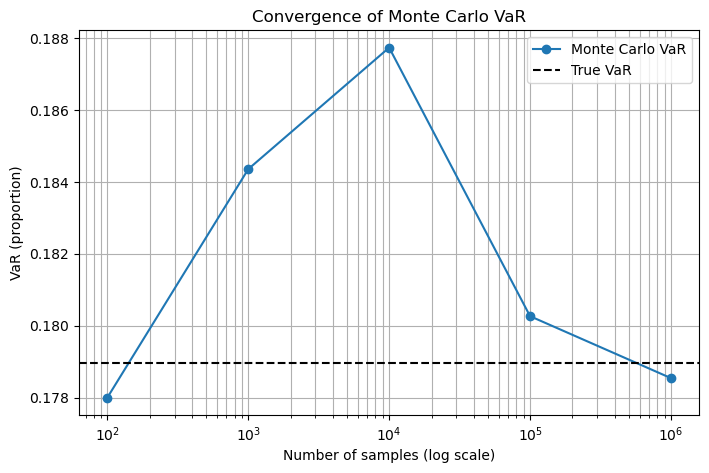

In [112]:
# Define sample sizes
sample_sizes = [10**k for k in range(2, 7)]   # 10^2 to 10^6

mc_estimates = []

# Compute Monte Carlo VaR for each N
for N in sample_sizes:
    VaR_est = mc_var(N)   # uses your Step 4 function
    mc_estimates.append(VaR_est)
    print(f"N = {N:7d}   MC VaR = {VaR_est:.6f}")

# Graphical Comparison

plt.figure(figsize=(8,5))
plt.plot(sample_sizes, mc_estimates, marker='o', label="Monte Carlo VaR")
plt.axhline(VaR_true, color='black', linestyle='--', label="True VaR")

plt.xscale("log")
plt.xlabel("Number of samples (log scale)")
plt.ylabel("VaR (proportion)")
plt.title("Convergence of Monte Carlo VaR")
plt.grid(True, which="both")
plt.legend()
plt.show()

From the graph above, it is natural to make the following conjecture:

$$
\lim_{N\to\infty} \widehat{\mathrm{VaR}}_{0.95}(N) \to VaR_{0.95}
$$

## 1.3 Proof & Error Analysis

From this empirical convergence, we now justify theoretically why the Monte Carlo VaR estimator converges to the true VaR and why its error scales like $1/\sqrt{N}$.

Let $F_L(x) = P(L \le x)$ be the true cumulative distribution function (CDF) of the loss $L$.
Let $F_{L,N}(x)$ be the empirical CDF constructed from $N$ Monte Carlo samples:

$$
F_{L,N}(x) = \frac{1}{N} \sum_{i=1}^N 1_{\{L_i \le x\}}.
$$

Each indicator variable $1_{\{L_i \le x\}}$ is Bernoulli, so estimating $F_L(x)$ at a fixed
point $x$ is the same as estimating a sample mean. By the Central Limit Theorem,

$$
F_{L,N}(x) - F_L(x) = O\left( \frac{1}{\sqrt{N}} \right).
$$

The true $95\%$ Value-at-Risk (VaR) is the $0.95$ quantile of the loss distribution:

$$
\mathrm{VaR}_{95} = F_L^{-1}(0.95).
$$

The Monte Carlo estimator of the VaR is the empirical quantile:

$$
\widehat{\mathrm{VaR}}_{95}(N) = F_{L,N}^{-1}(0.95).
$$

---


The empirical CDF $F_{L,N}(x)$ differs from $F_L(x)$ by an amount of order $1/\sqrt{N}$.
This is a *vertical* error: the estimated probability at a fixed value $x$ is off by about
$\delta = O(1/\sqrt{N})$.

To understand how this affects the VaR estimate, recall that $F_L(x)$ is differentiable
near the true VaR, with density $f_L(x) = F_L'(x)$ that is strictly positive there.
By a first-order Taylor expansion around the VaR,

$$
F_L(x + h) \approx F_L(x) + f_L(x)\,h.
$$

If $F_{L,N}(x)$ shifts by $\delta$, then the corresponding horizontal shift in the
quantile is approximately

$$
h \approx \frac{\delta}{f_L(x)}.
$$

Since $\delta = O(1/\sqrt{N})$ and $f_L(x)$ is a nonzero constant at the VaR,
the quantile error satisfies

$$
\widehat{\mathrm{VaR}}_{95}(N)
    - \mathrm{VaR}_{95}
    = O\left( \frac{1}{\sqrt{N}} \right).
$$

Thus the Monte Carlo estimate of the VaR inherits the same $1/\sqrt{N}$ rate as
the empirical CDF from which it is derived.

---


If the VaR error behaves like $1/\sqrt{N}$, then achieving a target accuracy
$\epsilon$ requires

$$
\frac{1}{\sqrt{N}} \approx \epsilon.
$$

Solving for $N$ gives

$$
N = O\left( \frac{1}{\epsilon^2} \right).
$$

This means that to reduce the VaR error by a factor of $10$, we must increase the
number of Monte Carlo samples by a factor of $100$. This quadratic dependence is a
fundamental limitation of classical Monte Carlo and is precisely why quantum amplitude
estimation offers a potential advantage, with its $O(1/\epsilon)$ scaling.


# 2. Alternative Hypotheses with Fat-Tailed Distributions

Recall the definition of VaR:

$$
\mathrm{VaR}_{1-\alpha} \equiv F_L^{-1}(\alpha).
$$

Since the level of significance $\alpha$ is generally very small, the value of the VaR is heavily determined by the *tail behaviour* of the probability distribution we choose.  
Geometrically, a fatter-tailed distribution yields a larger (more conservative) VaR.

In the first hypothesis, we assumed that $R_t$ follows a normal distribution,  
whose tail vanishes at a super-exponential rate:

$$
f_{\text{Normal}}(x) \sim e^{-x^2/(2\sigma^2)}.
$$

A natural continuation is to consider the Student–t and Cauchy distributions.  
These have **polynomially decaying tails**, which vanish much more slowly:

- **Student–t distribution (df = $\nu$)**  
  Tail of the pdf behaves as  
  $$
  f_{t_\nu}(x) \sim x^{-(\nu+1)}.
  $$
- **Cauchy distribution**  
  Tail of the pdf behaves as  
  $$
  f_{\text{Cauchy}}(x) \sim x^{-2}.
  $$

Since polynomial decay is far slower than exponential decay, these heavy-tailed distributions produce significantly larger VaR values,  
especially at high confidence levels.

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, cauchy

mu = 0.15
sigma = 0.20     # desired standard deviation for Normal and Student–t
nu = 10           # degrees of freedom for Student–t


## 2.1 Distribution Definitions

- **Normal distribution:**
  
  $$
  R = \mu + \sigma Z, \qquad Z \sim N(0,1).
  $$

- **Generalised Student–t distribution:**

  $$
  R = \mu + s \, T_\nu, \qquad T_\nu \sim t_\nu.
  $$

  The scale parameter $s$ is chosen to enforce a target standard deviation $\sigma$:

  $$
  s = \sigma \sqrt{\frac{\nu - 2}{\nu}}.
  $$

- **Generalised Cauchy distribution:**

  $$
  R = \mu + \gamma X, \qquad X \sim \text{Cauchy}(0,1).
  $$

  Cauchy has no finite variance, so we use  $ \gamma = \sigma $ for comparability.


In [114]:
# Student-t scale to enforce SD = sigma
std_t = np.sqrt(nu/(nu - 2))
scale_t = sigma / std_t

# Cauchy: no finite variance → pick scale = sigma
scale_cauchy = sigma

scale_t, scale_cauchy


(np.float64(0.17888543819998318), 0.2)

## 2.2 Analytical PDFs

We plot the analytical pdfs of the three distributions:

- Normal (light tails),
- Student–t (moderately heavy tails),
- Cauchy (extremely heavy tails).

These differences drive large differences in VaR estimates.


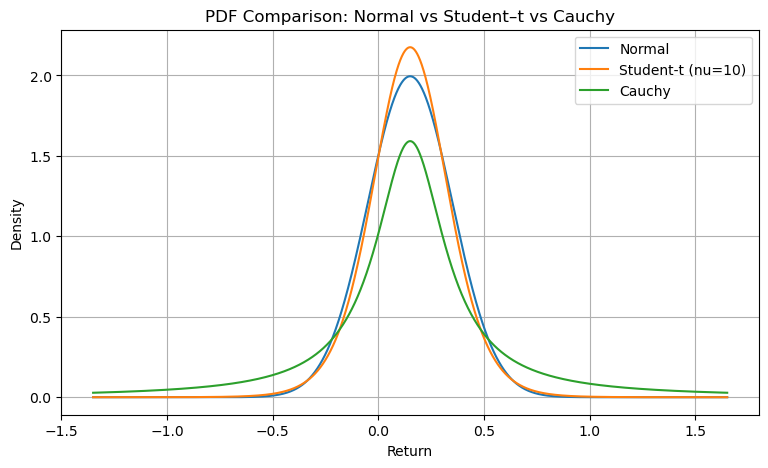

In [115]:
x = np.linspace(mu - 1.5, mu + 1.5, 2000)

pdf_normal = norm.pdf(x, loc=mu, scale=sigma)
pdf_t = t.pdf((x - mu)/scale_t, df=nu) / scale_t
pdf_c = cauchy.pdf(x, loc=mu, scale=scale_cauchy)

plt.figure(figsize=(9,5))
plt.plot(x, pdf_normal, label="Normal")
plt.plot(x, pdf_t, label=f"Student-t (nu={nu})")
plt.plot(x, pdf_c, label="Cauchy")
plt.title("PDF Comparison: Normal vs Student–t vs Cauchy")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


## 2.3 Analytical VaR (95%)

The 95% VaR is the 5% left-tail quantile of returns:

$$
\mathrm{VaR}_{0.95} = -F_R^{-1}(0.05).
$$

Below, we compute this analytically for all distributions.


In [116]:
# Normal VaR
z_n = norm.ppf(0.05)
VaR_normal = -(mu + sigma * z_n)

# Student-t VaR
z_t = t.ppf(0.05, df=nu)
VaR_t = -(mu + scale_t * z_t)

# Cauchy VaR
z_c = cauchy.ppf(0.05)
VaR_c = -(mu + scale_cauchy * z_c)

VaR_normal, VaR_t, VaR_c


(np.float64(0.1789707253902946),
 np.float64(0.17422290217443168),
 np.float64(1.112750302935009))

## 2.4 Monte Carlo VaR Estimates

We now simulate returns from each distribution and compute the Monte Carlo
95% VaR estimate:

$$
\widehat{\mathrm{VaR}}_{0.95}(N)
= \text{quantile}_{0.95}(-R_1, \dots, -R_N).
$$

Because fat-tailed distributions produce more extreme losses,
their Monte Carlo estimates converge more slowly.


In [117]:
def mc_var_normal(N):
    r = mu + sigma * np.random.randn(N)
    return np.quantile(-r, 0.95)

def mc_var_t(N):
    r = mu + scale_t * t.rvs(df=nu, size=N)
    return np.quantile(-r, 0.95)

def mc_var_cauchy(N):
    r = mu + scale_cauchy * cauchy.rvs(size=N)
    return np.quantile(-r, 0.95)


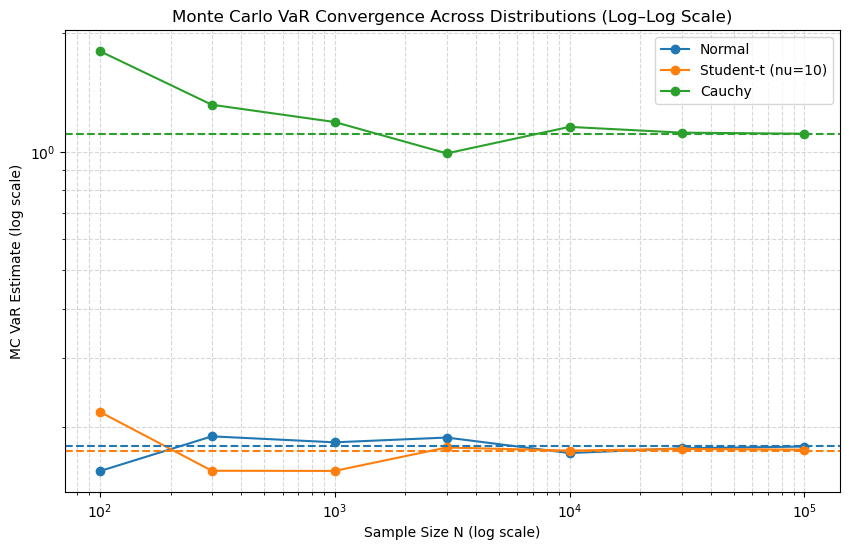

In [118]:
# Slightly more sample sizes (but not too many)
sample_sizes = [100, 300, 1_000, 3_000, 10_000, 30_000, 100_000]

mc_norm_vals = []
mc_t_vals    = []
mc_c_vals    = []

for N in sample_sizes:
    mc_norm_vals.append(mc_var_normal(N))
    mc_t_vals.append(mc_var_t(N))   # uses ν = 5
    mc_c_vals.append(mc_var_cauchy(N))

plt.figure(figsize=(10,6))

# plot MC curves
line_norm,  = plt.plot(sample_sizes, mc_norm_vals, marker='o', label="Normal")
line_t,     = plt.plot(sample_sizes, mc_t_vals,    marker='o', label=f"Student-t (nu={nu})")
line_cauchy,= plt.plot(sample_sizes, mc_c_vals,    marker='o', label="Cauchy")

# horizontal VaR lines (matching color)
plt.axhline(VaR_normal, color=line_norm.get_color(),   linestyle='--')
plt.axhline(VaR_t,      color=line_t.get_color(),      linestyle='--')
plt.axhline(VaR_c,      color=line_cauchy.get_color(), linestyle='--')

# log–log scaling
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Sample Size N (log scale)")
plt.ylabel("MC VaR Estimate (log scale)")
plt.title("Monte Carlo VaR Convergence Across Distributions (Log–Log Scale)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()






## 2.5 Effect of Varying the Degrees of Freedom ν in the Student–t Distribution

We now expand our comparison by investigating how the Student–t distribution
changes as we vary the degrees of freedom parameter ν.

Lower ν produces heavier tails, larger VaR, and slower Monte Carlo convergence.
As ν increases, the distribution approaches the normal distribution.

We will compute:

- analytical pdfs for several values of ν,
- analytical VaR for each ν,
- Monte Carlo VaR convergence for each ν.

This provides a detailed benchmark of numerical convergence vs tail thickness.


In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, cauchy

mu = 0.15           # shared mean
sigma = 0.20        # target standard deviation
nu_values = [3, 5, 10, 30, 100]   # ν sweep: heavy → light tails


###  2.5.1 Scale Parameter s(ν) for the Student–t Distribution

For a Student–t distribution with degrees of freedom ν, the standard deviation is

$$
\mathrm{SD}(T_\nu) = \sqrt{\frac{\nu}{\nu - 2}}.
$$

To match the target standard deviation σ for returns
we choose the scale parameter

$$
s_\nu = \sigma \sqrt{\frac{\nu - 2}{\nu}}.
$$

This ensures all Student–t distributions have the same SD, allowing fair comparison.


In [120]:
def compute_scale(nu, sigma=0.20):
    return sigma * np.sqrt((nu - 2) / nu)

scale_map = {nu: compute_scale(nu) for nu in nu_values}
scale_map


{3: np.float64(0.11547005383792515),
 5: np.float64(0.1549193338482967),
 10: np.float64(0.17888543819998318),
 30: np.float64(0.19321835661585918),
 100: np.float64(0.19798989873223333)}

### 2.5.2 PDF Comparison Across Different ν

As ν decreases, the Student–t distribution becomes sharper in the center and
develops much heavier tails.
As ν increases, it approaches the normal distribution.


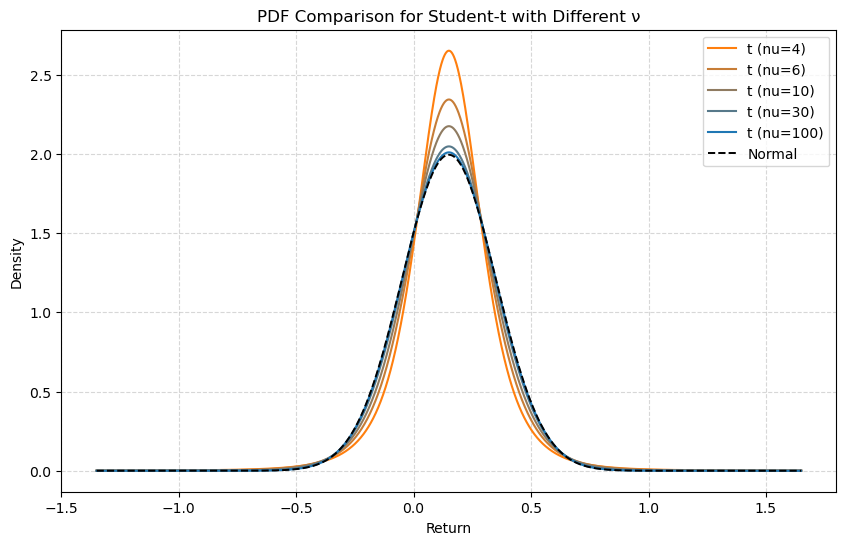

In [121]:
from scipy.stats import t, norm

# Parameters
mu = 0.15
sigma = 0.20

# ν values matching the ν-sweep
nu_values = [4, 6, 10, 30, 100]

# --- Scale parameter for Student-t (matched variance) ---
def t_scale(nu, sigma=sigma):
    return sigma * np.sqrt((nu - 2) / nu)

# x-range for PDFs
x = np.linspace(mu - 1.5, mu + 1.5, 2000)

# --- Custom color gradient: Matplotlib ORANGE → BLUE ---
orange = np.array([1.0, 0.498, 0.055])    # #ff7f0e
blue   = np.array([0.121, 0.466, 0.705])  # #1f77b4

colors = []
for i in range(len(nu_values)):
    tval = i / (len(nu_values)-1)
    colors.append((1 - tval) * orange + tval * blue)

# --- PLOT PDFs ---
plt.figure(figsize=(10,6))

for color, nu in zip(colors, nu_values):
    s = t_scale(nu)
    pdf_vals = t.pdf((x - mu)/s, df=nu) / s
    plt.plot(x, pdf_vals, color=color, label=f"t (nu={nu})")

# Normal reference
pdf_normal = norm.pdf(x, loc=mu, scale=sigma)
plt.plot(x, pdf_normal, '--', color='black', linewidth=1.4, label="Normal")

plt.xlabel("Return")
plt.ylabel("Density")
plt.title("PDF Comparison for Student-t with Different ν")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.show()




### 2.5.3 Analytical VaR (95%) for Different Degrees of Freedom

For each ν, the analytical VaR is

$$
\mathrm{VaR}_{0.95}(\nu)
= -\left( \mu + s_\nu \, t_\nu(0.05) \right).
$$

Smaller ν produces much heavier tails and significantly larger VaR values.


### 2.5.4 Monte Carlo VaR Convergence for Different ν

We now compute Monte Carlo VaR estimates for each ν and compare convergence.
Because heavy-tailed distributions generate more extreme losses,
their Monte Carlo VaR converges more slowly and with more noise.


In [122]:
def mc_var_t(N, nu, mu=0.15, sigma=0.20):
    s = compute_scale(nu, sigma)
    r = mu + s * t.rvs(df=nu, size=N)
    losses = -r
    return np.quantile(losses, 0.95)


In [123]:
sample_sizes = [10**k for k in range(2, 6)]  # 1e2 to 1e5

mc_vals = {nu: [] for nu in nu_values}

for nu in nu_values:
    for N in sample_sizes:
        mc_vals[nu].append(mc_var_t(N, nu))


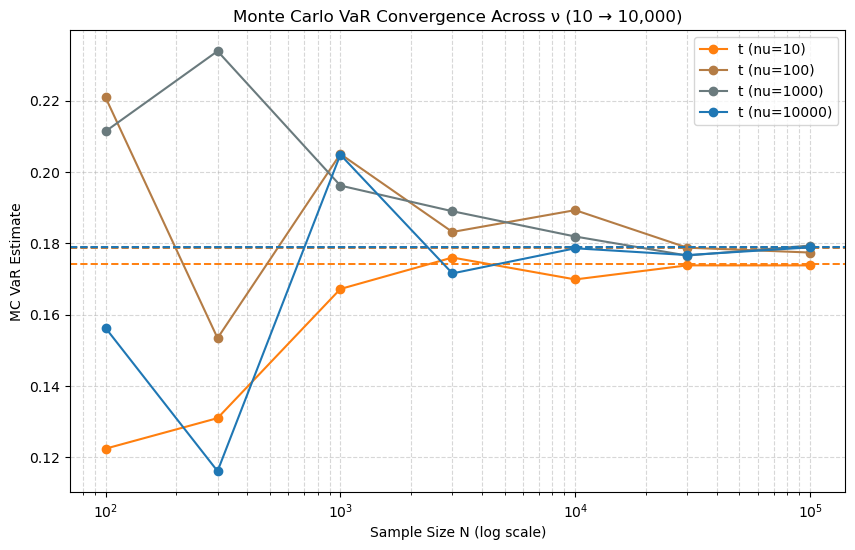

In [124]:
# Parameters
mu = 0.15
sigma = 0.20

# ν values: start at 10, increase by order of magnitude
nu_values = [10, 100, 1000, 10000]

# Sample sizes for MC VaR estimation
sample_sizes = [100, 300, 1000, 3000, 10000, 30000, 100000]

# --- MC VaR function with ν parameter ---
def mc_var_t(N, nu, mu=0.15, sigma=0.20):
    scale_t = sigma * np.sqrt((nu - 2) / nu)
    r = mu + scale_t * t.rvs(df=nu, size=N)
    losses = -r
    return np.quantile(losses, 0.95)

# --- Analytical VaR for each ν ---
VaR_t_map = {}
for nu in nu_values:
    scale_t = sigma * np.sqrt((nu - 2) / nu)
    q = t.ppf(0.05, df=nu)
    VaR_t_map[nu] = -(mu + scale_t * q)

# --- Monte Carlo VaR convergence data ---
mc_vals = {nu: [] for nu in nu_values}
for nu in nu_values:
    for N in sample_sizes:
        mc_vals[nu].append(mc_var_t(N, nu))

# --- Custom color gradient: Matplotlib ORANGE → BLUE ---
orange = np.array([1.0, 0.498, 0.055])    # #ff7f0e
blue   = np.array([0.121, 0.466, 0.705])  # #1f77b4

colors = []
for i in range(len(nu_values)):
    tval = i / (len(nu_values)-1)
    colors.append((1 - tval) * orange + tval * blue)

# --- Plot ---
plt.figure(figsize=(10,6))

for color, nu in zip(colors, nu_values):
    plt.plot(sample_sizes, mc_vals[nu], marker='o', color=color, label=f"t (nu={nu})")
    plt.axhline(VaR_t_map[nu], linestyle='--', linewidth=1.4, color=color)

plt.xscale("log")              # log X-axis
# plt.yscale("log")            # ❌ removed — linear Y-axis as requested

plt.xlabel("Sample Size N (log scale)")
plt.ylabel("MC VaR Estimate")
plt.title("Monte Carlo VaR Convergence Across ν (10 → 10,000)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()








## 2.6 Comparison of the 3 Hypotheses

Our analysis demonstrates that the rate at which Monte Carlo VaR converges is 
fundamentally governed by the tail properties of the assumed return distribution.

Normal returns, with exponentially decaying tails, yield the smallest VaR and the 
fastest numerical convergence. Student–t returns exhibit polynomial decay, and 
the convergence rate of the VaR estimator deteriorates as the degrees of freedom 
ν decrease. For small ν, the estimator variance is dominated by extreme losses, 
leading to slow and noisy convergence. The Cauchy case (ν = 1) illustrates the 
limit of this behaviour, with no finite moments and highly unstable VaR estimates.

These results show that heavier-tailed models impose a clear statistical cost: 
they provide more conservative and realistic tail quantiles, but at the expense 
of slower Monte Carlo convergence and higher estimator variance. The choice of ν 
balances realism against computational stability, with large ν approaching the 
Gaussian limit and small ν capture extreme-tail risk more faithfully.



## 2.7 Distinguishing Two Effects: VaR Magnitude vs Convergence Difficulty

It is important to separate two related but distinct phenomena:

1. **Why VaR is larger for small ν**  
   Heavy-tailed distributions assign more probability mass to extreme negative
   returns. This raises the 95% quantile of the loss distribution, producing a
   larger VaR.

2. **Why Monte Carlo convergence is slower for small ν**  
   The variance of the VaR estimator depends on the density at the quantile
   level:  
   $$\mathrm{Var}(\hat{q}_N) \propto \frac{1}{N f(q)^2}.$$

   For heavy-tailed distributions, the pdf \( f(q) \) at the tail quantile is
   *small*, which makes the estimator variance *large*. This leads to noisy
   estimates and slow convergence.

These are different mechanisms:

- **Heavy tails raise the true VaR.**
- **Heavy tails reduce the pdf at the quantile, increasing Monte Carlo variance.**

Together, these effects explain why fat-tailed models are both more conservative
and more computationally demanding.


# 3. Why This Matters for Quantum Algorithms

Classical Monte Carlo VaR estimation has a well-known sample complexity:

- To achieve error at most ε, classical Monte Carlo requires **O(1/ε²)** samples.

This becomes especially expensive when modeling **fat-tailed return distributions**, in
which VaR is dominated by rare extreme losses. In heavy-tailed settings:

- The pdf at the VaR level is small.
- The variance of the quantile estimator is large.
- Convergence is slow and requires large N.

Quantum Amplitude Estimation (QAE) improves the sample complexity to:

- **O(1/ε)** queries.

This quadratic improvement is most impactful in precisely the situations identified
by our experiments:

- distributions with heavy tails,
- high quantile levels (e.g. 95%, 99%, 99.5%),
- tasks where classical Monte Carlo converges slowly.

Thus, our classical analysis directly explains *where* and *why* quantum algorithms
may provide computational advantages in risk modeling.



## 4. Conclusion

Our results show that the behaviour of Value-at-Risk (VaR) is strongly governed
by the tail structure of the underlying return distribution. Normal returns
produce the smallest VaR and the smoothest Monte Carlo convergence, while
fat-tailed models such as the Student–t with small ν exhibit both higher true
VaR and substantially slower numerical convergence. This slowdown occurs because
heavy-tailed distributions have lower density in the tail region, which
increases the variance of the estimated quantile and requires much larger sample
sizes for stability.

By sweeping across different degrees of freedom ν, we quantified the transition
from heavy-tailed behaviour to near-Gaussian behaviour: VaR decreases and
convergence accelerates rapidly as ν increases. This demonstrates a fundamental
tradeoff in classical risk estimation—more realistic models of extreme events
are also more computationally demanding.

These classical bottlenecks are exactly where quantum algorithms, such as
Quantum Amplitude Estimation (QAE), offer potential advantages. Classical Monte
Carlo requires O(1/ε²) samples to reach precision ε, and this burden grows in
heavy-tailed settings. QAE achieves O(1/ε) scaling, providing a quadratic
improvement in sample efficiency and potentially large practical savings in
precisely the regimes where classical Monte Carlo struggles most.
